In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
import librosa
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras import Model
import unicodedata
import time
import tensorflow as tf

In [2]:
n_mels = 80
fs = 22050
frame_length_ms=50
frame_shift_ms=12.5
nsc = int(22050 * frame_length_ms / 1000)
nov = nsc - int(22050 * frame_shift_ms / 1000)
nhop = int(22050 * frame_shift_ms / 1000)
eps = 1e-10
db_ref = 100

chars = ' ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz!\'(),-.:;? '

num_tokens = len(chars)

embed_size = 256

K = 16

num_conv1d_filters = 128

prenet_size = [256, 128]

num_enc_proj_filters = [128, 128]

enc_highway_depth = 128

enc_bidirection_rnn_depth = 128 # 128 * 2

attention_depth = 128

dec_rnn_depth = [256, 256]

attention_rnn_depth = 256

dec_prenet_size = [256, 128]

r = 3

In [3]:
meta_path = "../datasets/metadata.csv"
# meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

dataset_size = len(metadata)

In [4]:
# character_length_ = list()
# file_length_ = list()
# division_length_ = list()

# wave_name_list = []

# for data in metadata:
#     wav_name = '{}.wav'.format(data[0])
#     wave_name_list.append(wav_name)
    
# data_folder = "../datasets/wavs"

# for i in tqdm(range(len(metadata))):
#     wav_path = os.path.join(data_folder, wave_name_list[i])
#     y, sr = librosa.core.load(wav_path)
    
#     character_length_.append(len(metadata[i, 1]))
#     file_length_.append(len(y) / sr)
#     division_length_.append(1000 * (len(y) / sr) / len(metadata[i, 1]))

In [5]:
# bins = range(0, 200, 5)
# plt.hist(division_length_, bins)

# plt.show()

In [6]:
meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [7]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))
    
#     if i not in error_jamos:
    for char in metadata[i, 3]:
        if char not in unicode_jamo_list:
            unicode_jamo_list.append(char)

In [8]:
unicode_jamo_list.sort()
print(unicode_jamo_list)
print(len(unicode_jamo_list))

chars = unicode_jamo_list + ['<end>']

print(chars)

num_tokens = len(chars) + 1

[' ', '!', ',', '.', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆴ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
69
[' ', '!', ',', '.', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆴ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ', '<end>']


In [9]:
unicode_jamo_list[1] == '!'

True

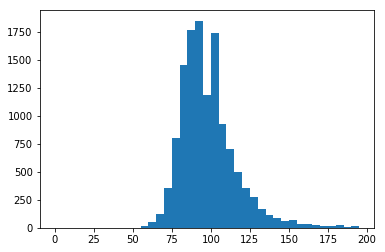

In [10]:
# plt.plot(character_length)
bins = range(0, 200, 5)
plt.hist(division_length, bins)

plt.show()

In [11]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])
    
data_folder = "D:/korean-single-speaker-speech-dataset/kss"
specgram_folder = "D:/korean-single-speaker-speech-dataset/kss/specgrams"
mel_folder = "D:/korean-single-speaker-speech-dataset/kss/mels"

In [12]:
"""

Preprocessing Step

"""

# for i, wav_name in tqdm(enumerate(wave_name_list)):
#     wav_path = os.path.join(data_folder, wav_name)
    
#     npy_name = wav_name.replace('.wav', '.npy')
    
#     specgram_path = os.path.join(specgram_folder, npy_name)
#     mel_path = os.path.join(mel_folder, npy_name)
    
#     y, sr = librosa.core.load(wav_path)
    
#     f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)

#     Sxx = np.abs(Zxx)
#     Sxx = np.maximum(Sxx, eps)

#     # plt.figure(figsize=(20,20))
#     # plt.imshow(20*np.log10(Sxx), origin='lower')
#     # plt.colorbar()
#     # plt.show()

#     mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)

#     mel_specgram = np.matmul(mel_filters, Sxx)

#     log_specgram = 20*np.log10(Sxx)

#     norm_log_specgram = (log_specgram + db_ref) / db_ref

#     log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))

#     norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref
    
# #     np.save(specgram_path, norm_log_specgram)
# #     np.save(mel_path, norm_log_mel_specgram)
#     np.save(specgram_path, Sxx)
#     np.save(mel_path, norm_log_mel_specgram)
    
# #     print(norm_log_mel_specgram.shape[1])

#     if i % 1000 == 0:

#         plt.figure(figsize=(16,9))
#         plt.imshow(Sxx, origin='lower', aspect='auto')
#         plt.colorbar()
#         plt.show()

#         plt.figure(figsize=(16,9))
#         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
#         plt.colorbar()
#         plt.show()    
# #     break

'\n\nPreprocessing Step\n\n'

In [20]:
embedding_layer = tf.keras.layers.Embedding(num_tokens, embed_size)

def initialize_GO_frame(batch_size, n_mels):
    return tf.zeros((batch_size, r, n_mels))


def flatten_r_frame(input_tensor, batch_size):
    return tf.reshape(input_tensor, [batch_size, 1, -1])


class Conv1D_Bank(tf.keras.Model):
    
    def __init__(self, num_filters, K):
        super(Conv1D_Bank, self).__init__()
        
        self.K = K
        
        self.conv1d_filters = [tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=k+1, filters=num_filters, padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu')])
                               for k in range(K)]
        
    def call(self, input_tensor):
        
        intermediate_results = []
        
        for k in range(self.K):
            conv_k_result = self.conv1d_filters[k](input_tensor)
            intermediate_results.append(conv_k_result)
        
        output_tensor = tf.concat(intermediate_results, axis = -1) 
        
        return output_tensor
    
class HighwayNet(tf.keras.Model):
    def __init__(self, num_units):
        super(HighwayNet, self).__init__()
        self.T = tf.keras.layers.Dense(units=num_units, activation='sigmoid',
                                        bias_initializer=tf.constant_initializer(-1.0))
        self.H = tf.keras.layers.Dense(units=num_units, activation='relu')

    def call(self, input_tensor):
        output_tensor = self.H(input_tensor) * self.T(input_tensor) + input_tensor * (1 - self.T(input_tensor))
        return output_tensor
    
'''
https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention

'''
    
class BahdanauAttention(tf.keras.Model):
    def __init__(self):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(attention_depth)
        self.W2 = tf.keras.layers.Dense(attention_depth)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.expand_dims(context_vector, axis=1)

        return context_vector, attention_weights
    
class ResidualGRU(tf.keras.Model):
    def __init__(self, units, return_sequences, recurrent_initializer='glorot_uniform'):
        super(ResidualGRU, self).__init__()
        self.units = units
        self.gru_layer = tf.keras.layers.GRU(units, return_sequences=True, recurrent_initializer=recurrent_initializer)

    def call(self, input_tensor, initial_state):
        output_tensor = self.gru_layer(input_tensor, initial_state = initial_state)
        
        residual_ouput_tensor = tf.add(output_tensor, input_tensor[:, :, :self.units])
        
        return residual_ouput_tensor
    
    
class StackedResidualRNN(tf.keras.Model):
    def __init__(self):
        super(StackedResidualRNN, self).__init__()
        self.depth = dec_rnn_depth
        self.residual_grues = [ResidualGRU(dec_rnn_depth[0], return_sequences=True, recurrent_initializer='glorot_uniform'),
                               ResidualGRU(dec_rnn_depth[1], return_sequences=True, recurrent_initializer='glorot_uniform')]

    def call(self, input_tensor, hidden_states):

        for i, residual_gru in enumerate(self.residual_grues):
            output_tensor = residual_gru(input_tensor, initial_state=hidden_states[i])
            hidden_states[i] = tf.reshape(output_tensor, [output_tensor.shape[0], -1])

        return output_tensor, hidden_states
    
    def initialize_hidden_states(self, batch_size):
        return [tf.zeros((batch_size, dec_rnn_depth[0])), tf.zeros((batch_size, dec_rnn_depth[1]))]      

class AttentionRNN(tf.keras.Model):
    def __init__(self):
        super(AttentionRNN, self).__init__()
        self.depth = attention_rnn_depth
        self.gru_cell = tf.keras.layers.GRU(self.depth, return_sequences=True, recurrent_initializer='glorot_uniform')

    def call(self, input_tensor, initial_state):
        output_tensor = self.gru_cell(input_tensor, initial_state=initial_state)
        hidden_state = output_tensor
        hidden_state = tf.reshape(hidden_state, [hidden_state.shape[0], -1])

        return output_tensor, hidden_state
    
    def initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.depth))      

class DecoderRNN(tf.keras.Model):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        self.dec_rnn_depth = dec_rnn_depth
        self.att_rnn_depth = attention_rnn_depth
        
        self.attention_rnn_layer = AttentionRNN()
        self.residual_rnn_layers = StackedResidualRNN()
        
    def call(self, input_tensor, hidden_states, context_vector):
                
        state, hidden_states[0] = self.attention_rnn_layer(input_tensor, initial_state=hidden_states[0])
        
        res_rnn_input_tensor = tf.concat([state, context_vector], axis=-1)
        
        output_tensor, hidden_states[1:3] = self.residual_rnn_layers(res_rnn_input_tensor, hidden_states[1:3])
        
        return output_tensor, hidden_states
    
    def initialize_hidden_states(self, batch_size):
        hidden_states = [self.attention_rnn_layer.initialize_hidden_state(batch_size)] + self.residual_rnn_layers.initialize_hidden_states(batch_size)
        return hidden_states
    
class DecoderPrenet(tf.keras.Model):
    def __init__(self):
        super(DecoderPrenet, self).__init__()
        self.decoder_prenet_layer = tf.keras.Sequential([tf.keras.layers.Dense(dec_prenet_size[0]),
                         tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Activation('relu'),
                         tf.keras.layers.Dropout(0.5),
                         tf.keras.layers.Dense(dec_prenet_size[1]),
                         tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Activation('relu'),
                         tf.keras.layers.Dropout(0.5)])
        
    def call(self, input_tensor):
        output_tensor = self.decoder_prenet_layer(input_tensor)
        return output_tensor
        
class MelPredictor(tf.keras.Model):
    def __init__(self):
        super(MelPredictor, self).__init__()
        self.mel_dense_layers = [tf.keras.layers.Dense(n_mels) for i in range(r)]
        self.r = r
    
    def call(self, input_tensor):
        
        output = []
        
        for i, dense_layer in enumerate(self.mel_dense_layers):
            output.append(dense_layer(input_tensor))
            
        output_tensor = tf.concat(output, axis=1)
        
        return output_tensor
    
class CBHG(tf.keras.Model):
    def __init__(self, num_conv1d_filters, K, num_proj_filters, highway_depth, bidirection_rnn_depth):
        super(CBHG, self).__init__()
        self.conv1d_bank = Conv1D_Bank(num_conv1d_filters, K)
        self.max_pooling_layer = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        self.projection_layer = tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=3, filters=num_proj_filters[0], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu'),
                                                   tf.keras.layers.Conv1D(kernel_size=3, filters=num_proj_filters[1], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('linear')
                                                   ])
        
        self.highway_preprocess_layer = tf.keras.layers.Dense(highway_depth)
        
        self.highway_layer = tf.keras.Sequential([HighwayNet(highway_depth) for i in range(4)])
        
        self.bi_gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(bidirection_rnn_depth, return_sequences=True), merge_mode="concat")

        
    def call(self, input_tensor):
        
        bank_output = self.conv1d_bank(input_tensor)
        max_pool_output = self.max_pooling_layer(bank_output) 
        projection_output = self.projection_layer(max_pool_output)
        
        residual_output = tf.add(projection_output, input_tensor)
        
        highway_intput = self.highway_preprocess_layer(residual_output)
        highway_output = self.highway_layer(highway_intput)
        output_tensor = self.bi_gru_layer(highway_output)
        
        return output_tensor
        

class Tacotron():
    
    def __init__(self):
        super(Tacotron, self).__init__()
        
        self.embedding_layer = tf.keras.layers.Embedding(num_tokens, embed_size) 

        self.encoder_prenet_layer = tf.keras.Sequential([tf.keras.layers.Dense(prenet_size[0], input_shape=(None, embed_size)),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Activation('relu'),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.Dense(prenet_size[1]),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Activation('relu'),
                                 tf.keras.layers.Dropout(0.5)], name='Encoder_Prenet')
    
        self.encoder_conv_bank_layer = Conv1D_Bank(num_conv1d_filters, K)
        
        self.enc_max_pooling_layer = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        
        self.enc_proj_layer = tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=3, filters=num_enc_proj_filters[0], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu'),
                                                   tf.keras.layers.Conv1D(kernel_size=3, filters=num_enc_proj_filters[1], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('linear')
                                                   ])
        
        self.enc_highway_layer = tf.keras.Sequential([HighwayNet(128) for i in range(4)])
    
        self.enc_bi_rnn_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(enc_bidirection_rnn_depth, return_sequences=True), merge_mode="concat")

        self.attention_layer = BahdanauAttention()
        
        self.decoder_rnn_layer = DecoderRNN()
        
        self.decoder_prenet_layer = DecoderPrenet()
        
        self.mel_pred_layer = MelPredictor()
        
        self.post_processing_cbhg = CBHG(128, 8, (256, 80), 128, 128)
        
        self.final_dense_layer = tf.keras.layers.Dense(552)
        
        self.L1 = tf.keras.losses.MeanAbsoluteError()
        
#         self.L2 = tf.keras.losses.MeanSquaredError()

        self.optimizer = tf.keras.optimizers.Adam()
     
#     @tf.function
    def train(self, mel, linear, input_tensor):
        
        batch_size = input_tensor.shape[0]
        sequence_length = input_tensor.shape[1]
        
        with tf.GradientTape() as tape:
            
            embedded = self.embedding_layer(input_tensor)
            encoded = self.encoder_prenet_layer(embedded)
            banked = self.encoder_conv_bank_layer(encoded)
            max_pooled = self.enc_max_pooling_layer(banked)
            projected = self.enc_proj_layer(max_pooled)
            residual_output = tf.add(encoded, projected)
            highway_output = self.enc_highway_layer(residual_output)
            encoder_output = self.enc_bi_rnn_layer(highway_output)
            
            hidden_state = encoder_output[:, -1, :]
            hidden_states = self.decoder_rnn_layer.initialize_hidden_states(batch_size)
            hidden_states[0] = hidden_state

            frames = []
            frame = initialize_GO_frame(batch_size, n_mels)

            for i in range(sequence_length):
                flat_frame = flatten_r_frame(frame, batch_size)
                decoder_rnn_input = self.decoder_prenet_layer(flat_frame)
                context_vector, _ = self.attention_layer(hidden_states[0], encoder_output)
                decoder_rnn_output, hidden_states = self.decoder_rnn_layer(decoder_rnn_input, hidden_states, context_vector)

                mel_frame = self.mel_pred_layer(decoder_rnn_output)
                
                frames.append(mel_frame)
                
                #frame = mel_frame #No force teaching
                
                frame = mel[:, r*(i):r*(i+1), :] # Force teaching
                
            
            mel_pred = tf.concat(frames, axis=1)
            post_cbhg_output = self.post_processing_cbhg(mel_pred)
            linear_pred = self.final_dense_layer(post_cbhg_output)

            mel_loss = self.L1(mel[:, :mel_pred.shape[1], :], mel_pred)
            linear_loss = self.L1(linear[:, :linear_pred.shape[1], :], linear_pred)
            total_loss = mel_loss + linear_loss
            
#             print("Loss Calculated")
#             print(time.strftime("%Hh %Mm %Ss"))
            
            variables = self.embedding_layer.trainable_variables + self.encoder_prenet_layer.trainable_variables + \
            self.encoder_conv_bank_layer.trainable_variables + self.enc_max_pooling_layer.trainable_variables + \
            self.enc_proj_layer.trainable_variables + self.enc_highway_layer.trainable_variables + \
            self.enc_bi_rnn_layer.trainable_variables + self.attention_layer.trainable_variables + \
            self.decoder_rnn_layer.trainable_variables + self.decoder_prenet_layer.trainable_variables + \
            self.mel_pred_layer.trainable_variables + self.post_processing_cbhg.trainable_variables + \
            self.final_dense_layer.trainable_variables
            
            gradients = tape.gradient(total_loss, variables)
            
            self.optimizer.apply_gradients(zip(gradients, variables))
        
        return total_loss / (r * sequence_length), mel_pred, linear_pred
        
        

In [21]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False, char_level=True)
tokenizer.fit_on_texts(chars)

tokenized_texts = tokenizer.texts_to_sequences(metadata[:, 3])

def dataset_generator():
    for file_name, tokens in zip(metadata[:, 0], tokenized_texts):
        linear_path = os.path.join(specgram_folder, file_name.replace('.wav', '.npy'))
        mel_path = os.path.join(mel_folder, file_name.replace('.wav', '.npy'))
        mel_target = np.load(mel_path)
        linear_target = np.load(linear_path)
        yield mel_target.T, linear_target.T, tokens

    return

In [22]:
dataset = tf.data.Dataset.from_generator(dataset_generator, (tf.float32, tf.float32, tf.int32), output_shapes=(tf.TensorShape([None, n_mels]), tf.TensorShape([None, 552]),tf.TensorShape([None, ])))

# dataset.shuffle(dataset_size)

In [23]:
def element_length_function(mel, linear, tokens):
    key = tf.size(tokens)
    return key

batch_size = 16

sequence_lengths = [i + 1 for i in range(16, max_sequence_len, 16)]
batch_sizes = [batch_size for i in range(len(sequence_lengths) + 1)]

dataset = dataset.apply(tf.data.experimental.bucket_by_sequence_length(element_length_function, sequence_lengths, batch_sizes))
dataset = dataset.prefetch(64)

17h 51m 17s


W0807 17:51:20.854490  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.0013755498, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 3.6 sec
17h 51m 21s


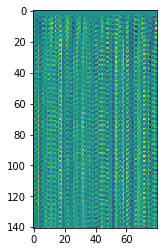

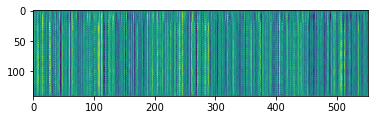

W0807 17:51:22.943966  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:51:24.652355  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:51:27.603026  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 17:52:06.348848  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:52:08.281288  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:52:09.656601  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 17:52:47.256162  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:52:49.047570  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:52:50.269848  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 17:53:30.626037  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:53:32.360432  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:53:34.115832  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 17:54:15.352220  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:54:17.040605  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:54:19.768226  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0007161021, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 179.6 sec
17h 54m 21s


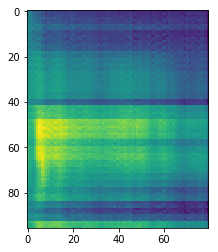

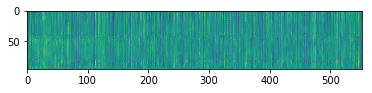

W0807 17:54:23.072979  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:54:25.810602  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:54:27.554999  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 17:55:05.913733  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:55:08.387296  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:55:10.108687  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 17:55:52.653375  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:55:54.529803  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:55:55.750080  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 17:56:34.135820  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:56:35.434115  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:56:38.177740  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 17:57:21.828678  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:57:23.621087  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:57:27.674010  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0006817944, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 188.0 sec
17h 57m 29s


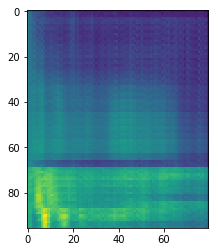

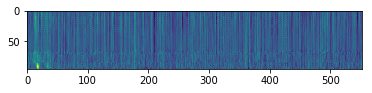

W0807 17:57:30.978763  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:57:33.599359  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:57:35.421774  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 17:58:17.536363  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:58:19.292763  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:58:21.839342  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 17:59:06.179438  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:59:10.563436  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:59:11.821723  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 17:59:48.127992  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:59:49.835381  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 17:59:52.835064  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:00:33.650357  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:00:36.959111  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:00:38.291414  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.0004611971, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 191.0 sec
18h 00m 40s


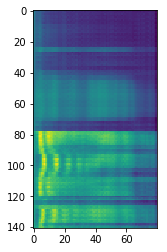

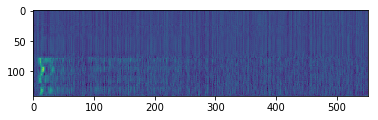

W0807 18:00:41.576162  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:00:43.216535  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:00:45.598078  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:01:30.769362  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:01:32.030650  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:01:33.654019  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:02:21.090820  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:02:23.788434  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:02:25.145745  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:03:08.719665  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:03:10.535078  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:03:11.802366  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:03:49.642982  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:03:50.976286  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:03:52.698678  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 30)
tf.Tensor(0.00066530524, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 194.0 sec
18h 03m 54s


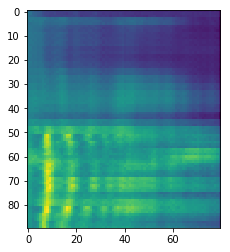

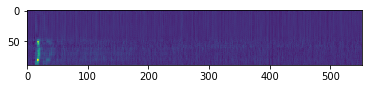

W0807 18:03:55.917411  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:03:58.461990  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:03:59.724277  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:04:42.352983  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:04:43.705291  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:04:45.435685  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:05:17.122900  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:05:18.844292  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:05:20.146589  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:05:56.578884  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:05:59.305505  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:06:01.035899  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:06:38.177355  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:06:40.679925  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:06:41.887200  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 45)
tf.Tensor(0.00047872425, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 169.5 sec
18h 06m 43s


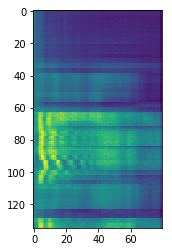

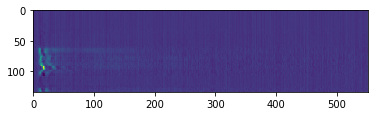

W0807 18:06:45.054921  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:06:46.775313  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:06:47.568494  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:07:23.595696  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:07:25.385104  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:07:26.644391  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:08:03.146702  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:08:04.383983  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:08:06.195395  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:08:42.188591  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:08:44.926214  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:08:46.164496  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:09:26.373651  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:09:28.199067  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:09:29.447351  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00044365396, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 167.6 sec
18h 09m 31s


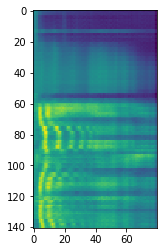

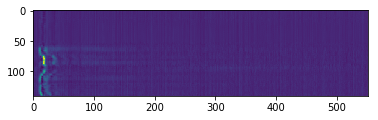

W0807 18:09:32.642078  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:09:35.815801  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:09:37.503185  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:10:16.646097  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:10:17.435278  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:10:19.248691  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:10:58.615653  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:10:59.908948  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:11:01.640342  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:11:37.398484  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:11:38.641767  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:11:40.453179  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:12:17.015506  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:12:19.711122  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:12:21.441515  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0005710711, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 171.6 sec
18h 12m 22s


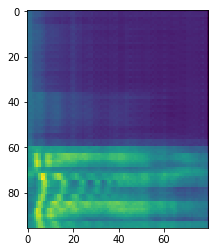

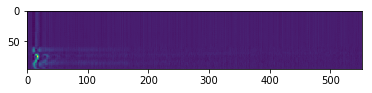

W0807 18:12:25.357407  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:12:26.566682  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:12:28.358089  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:13:05.398523  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:13:07.054900  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:13:08.851310  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:13:48.940437  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:13:51.229959  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:13:53.022367  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:14:29.681713  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:14:31.446115  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:14:32.693399  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:15:10.533015  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:15:13.227628  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:15:14.494918  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 48)
tf.Tensor(0.0004007462, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 173.6 sec
18h 15m 16s


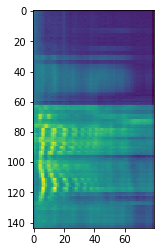

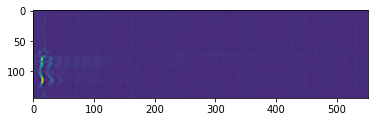

W0807 18:15:17.682643  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:15:20.428268  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:15:23.504968  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

In [25]:
tacotron = Tacotron()

# Started hour
print(time.strftime("%Hh %Mm %Ss"))

start = time.time()

for i, (mel, linear, texts) in enumerate(tqdm((dataset))):
    
    loss, spec, mel = tacotron.train(mel, linear, texts)
    
    if i % 100 == 0:
        print(texts.shape)    
        print(loss)
        print('Time taken for 100 * 16 samples: {:.1f} sec'.format(time.time() - start))
        print(time.strftime("%Hh %Mm %Ss"))
        start = time.time()
        
        plt.figure()
        plt.imshow(spec[0])
        plt.show()
        
        plt.figure()
        plt.imshow(mel[0])
        plt.show()
        
        print('')
        

18h 25m 38s


W0807 18:25:41.183605  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.0005497849, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.8 sec
18h 25m 41s


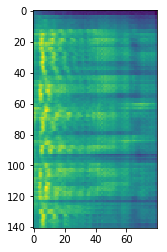

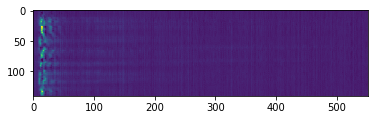

W0807 18:25:42.733959  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:25:44.517365  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:25:47.558057  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:26:25.752754  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:26:27.650185  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:26:28.934478  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:27:05.953907  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:27:07.691302  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:27:08.990599  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:27:49.186750  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:27:50.896140  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:27:52.653539  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:28:33.581858  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:28:35.430279  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:28:38.181906  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0005106608, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 178.2 sec
18h 28m 39s


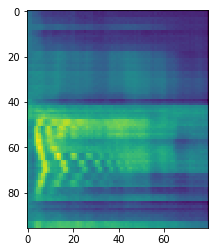

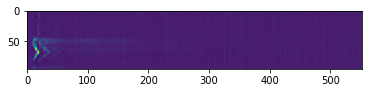

W0807 18:28:41.380634  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:28:44.175271  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:28:45.923668  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:29:24.527458  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:29:27.014024  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:29:28.743418  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:30:08.915565  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:30:10.725977  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:30:11.940254  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:30:47.590370  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:30:48.880664  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:30:51.556273  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:31:30.633170  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:31:32.430580  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:31:35.498279  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0004921892, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 177.3 sec
18h 31m 36s


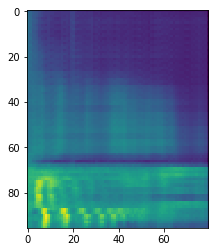

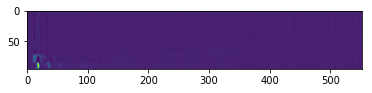

W0807 18:31:38.660998  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:31:41.278594  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:31:43.017991  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:32:23.533216  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:32:25.353631  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:32:27.917214  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:33:08.244395  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:33:11.522141  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:33:12.782429  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:33:48.736615  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:33:50.553028  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:33:53.500700  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:34:34.445023  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:34:37.825792  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:34:39.190103  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00039161099, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 184.1 sec
18h 34m 41s


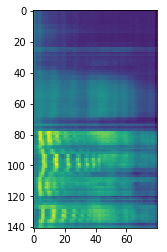

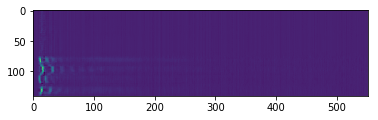

W0807 18:34:42.382829  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:34:44.149232  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:34:46.566783  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:35:31.902105  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:35:33.221405  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:35:34.946799  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:36:22.311582  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:36:25.178235  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:36:26.496535  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:37:08.362067  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:37:10.173480  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:37:11.437767  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:37:49.075337  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:37:50.326622  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:37:52.122030  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 30)
tf.Tensor(0.00058932736, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 192.4 sec
18h 37m 53s


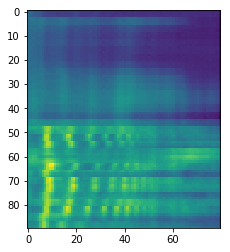

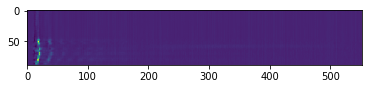

W0807 18:37:55.384773  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:37:57.913350  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:37:59.268658  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:38:40.230985  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:38:41.484270  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:38:43.215664  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:39:14.305743  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:39:16.023134  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:39:17.332432  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:39:53.866750  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:39:56.517354  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:39:58.340769  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:40:35.570246  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:40:38.075816  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:40:39.292094  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 45)
tf.Tensor(0.00042860053, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 167.6 sec
18h 40m 41s


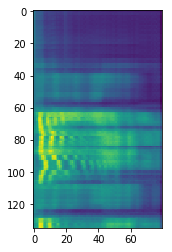

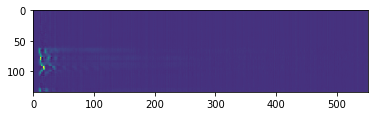

W0807 18:40:42.480819  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:40:44.216214  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:40:45.023398  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:41:21.145623  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:41:22.937031  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:41:24.198318  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:42:00.294537  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:42:01.539819  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:42:03.373237  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:42:39.567479  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:42:42.323106  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:42:43.575391  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:43:23.838558  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:43:25.662973  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:43:26.909257  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00040532608, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 167.7 sec
18h 43m 28s


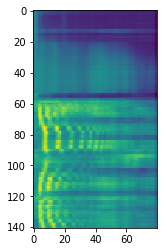

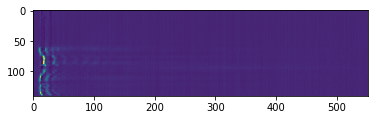

W0807 18:43:30.099984  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:43:33.305714  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:43:35.017103  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:44:14.179020  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:44:14.960198  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:44:16.707596  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:44:56.161579  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:44:57.396861  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:44:59.218275  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:45:34.839385  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:45:36.071666  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:45:37.878077  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:46:12.208894  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:46:14.886504  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:46:16.612896  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0005329579, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 169.4 sec
18h 46m 18s


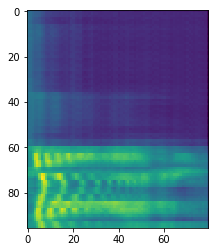

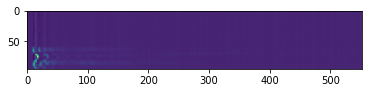

W0807 18:46:19.749611  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:46:20.968888  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:46:22.760296  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:46:59.554674  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:47:01.197047  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:47:03.000458  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:47:42.028344  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:47:44.234847  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:47:46.043259  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:48:22.853640  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:48:24.529021  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:48:25.833318  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:49:02.971775  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:49:05.653384  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:49:06.890666  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 48)
tf.Tensor(0.00037662272, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 170.6 sec
18h 49m 08s


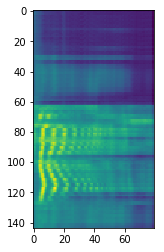

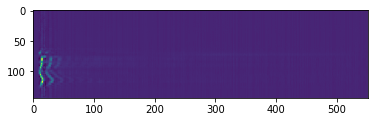

W0807 18:49:09.496261  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:49:10.732541  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:49:12.166868  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:49:17.590102  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00052480376, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.7 sec
18h 49m 17s


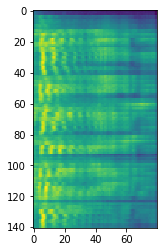

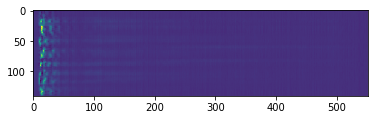

W0807 18:49:19.023429  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:49:20.744821  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:49:23.729501  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:50:01.775163  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:50:03.485553  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:50:04.837860  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:50:41.823904  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:50:43.650319  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:50:44.902605  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:51:25.234788  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:51:26.974184  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:51:28.751589  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:52:09.776929  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:52:11.469314  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:52:14.220942  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.000493686, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 177.9 sec
18h 52m 15s


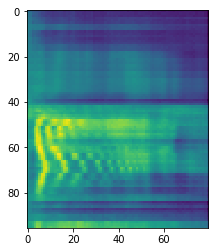

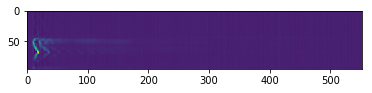

W0807 18:52:17.480683  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:52:20.295324  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:52:21.962704  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:53:00.820552  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:53:03.316120  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:53:05.057516  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:53:45.481720  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:53:47.306136  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:53:48.538417  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:54:24.702652  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:54:25.932931  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:54:28.663552  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:55:08.123536  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:55:09.916945  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:55:13.030654  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00046661028, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 178.9 sec
18h 55m 14s


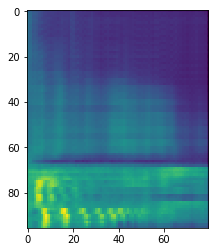

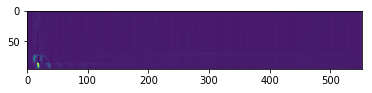

W0807 18:55:16.323404  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:55:19.065028  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:55:20.844434  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:56:01.557703  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:56:03.365115  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:56:05.903692  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:56:46.153857  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:56:49.366588  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:56:50.690890  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:57:26.268990  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:57:28.053396  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:57:31.050078  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:58:10.968168  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:58:14.193902  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:58:15.521205  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00037205138, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.9 sec
18h 58m 17s


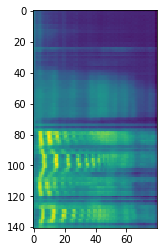

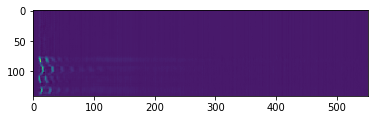

W0807 18:58:18.784947  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:58:20.419319  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:58:22.804863  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:59:06.215747  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:59:07.477035  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:59:09.074398  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 18:59:54.452730  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:59:57.147343  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 18:59:58.496650  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:00:40.390189  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:00:42.182597  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:00:43.446885  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:01:21.096457  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:01:22.405755  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:01:24.133149  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 30)
tf.Tensor(0.0005578553, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 188.2 sec
19h 01m 25s


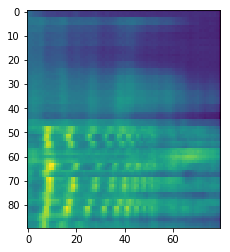

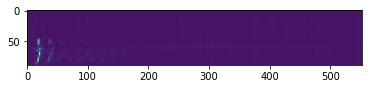

W0807 19:01:27.313874  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:01:29.847450  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:01:31.103736  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:02:12.095070  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:02:13.351355  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:02:15.176771  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:02:46.004790  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:02:47.719180  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:02:49.025477  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:03:25.554795  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:03:28.267412  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:03:30.073824  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:04:07.162268  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:04:09.558815  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:04:10.838105  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 45)
tf.Tensor(0.00041271225, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 167.1 sec
19h 04m 12s


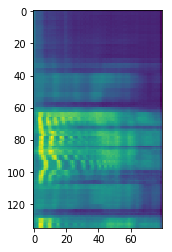

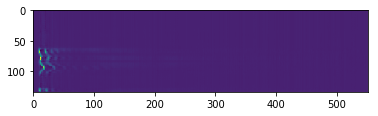

W0807 19:04:13.983822  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:04:15.699212  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:04:16.498394  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:04:52.475586  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:04:54.258992  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:04:55.513277  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:05:31.722521  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:05:32.962804  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:05:34.784219  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:06:10.784415  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:06:13.514036  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:06:14.766322  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:06:54.805438  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:06:56.643857  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:06:57.902144  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00038489548, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 167.2 sec
19h 06m 59s


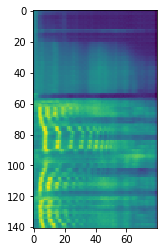

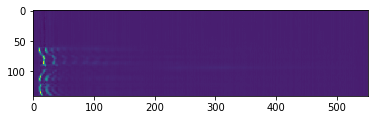

W0807 19:07:01.121876  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:07:04.311603  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:07:06.013990  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:07:45.145900  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:07:45.931079  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:07:47.662473  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:08:27.136461  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:08:28.370742  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:08:30.164151  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:09:05.767256  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:09:07.081556  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:09:08.825953  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:09:43.106758  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:09:45.770365  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:09:47.574777  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0005163093, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 169.1 sec
19h 09m 48s


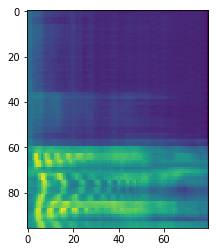

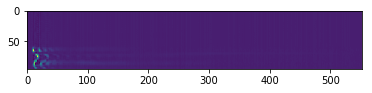

W0807 19:09:50.548453  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:09:51.851750  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:09:53.566140  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:10:30.411530  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:10:32.115918  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:10:33.861314  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:11:12.993224  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:11:15.202727  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:11:17.004138  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:11:53.730500  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:11:55.408882  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:11:56.724181  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:12:33.790621  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:12:36.460229  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:12:37.702512  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 48)
tf.Tensor(0.00036109315, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 170.6 sec
19h 12m 39s


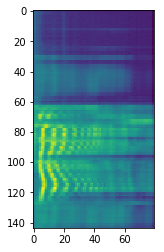

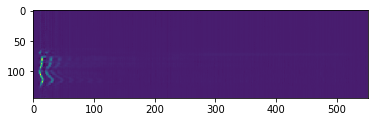

W0807 19:12:40.301103  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:12:41.534384  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:12:42.968711  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:12:48.361939  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.000507015, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.7 sec
19h 12m 48s


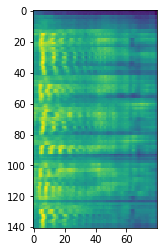

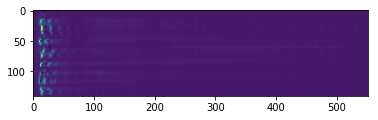

W0807 19:12:49.784262  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:12:51.487650  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:12:54.451325  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:13:32.604012  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:13:34.321403  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:13:35.657707  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:14:12.539105  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:14:14.238492  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:14:15.455769  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:14:55.446874  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:14:57.196273  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:14:58.961674  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:15:39.676944  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:15:41.440346  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:15:44.159965  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0004749078, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 177.1 sec
19h 15m 45s


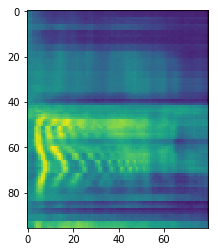

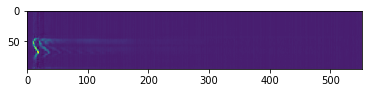

W0807 19:15:47.357693  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:15:50.144328  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:15:51.879723  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:16:30.177443  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:16:32.648006  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:16:34.387402  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:17:14.524540  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:17:16.351957  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:17:17.570234  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:17:53.067316  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:17:54.292595  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:17:57.024217  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:18:36.037100  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:18:37.823506  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:18:40.791182  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00045597067, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 176.7 sec
19h 18m 42s


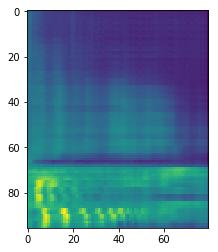

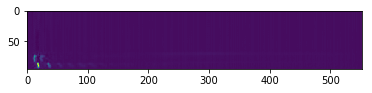

W0807 19:18:44.025918  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:18:46.643514  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:18:48.375909  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:19:28.945146  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:19:30.728552  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:19:33.279133  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:20:13.330252  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:20:16.614000  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:20:17.863284  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:20:53.310355  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:20:55.100762  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:20:58.107447  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:21:37.908509  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:21:41.206261  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:21:42.532562  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00036160255, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.1 sec
19h 21m 44s


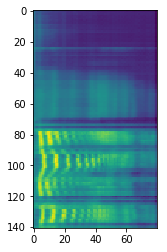

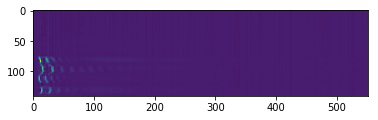

W0807 19:21:45.762298  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:21:47.390668  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:21:49.756207  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:22:33.116080  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:22:34.357362  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:22:35.964728  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:23:21.216031  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:23:23.918647  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:23:25.253951  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:24:07.067471  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:24:08.857878  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:24:10.117166  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:24:47.772739  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:24:49.112044  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:24:50.836436  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 30)
tf.Tensor(0.00054707716, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 187.8 sec
19h 24m 52s


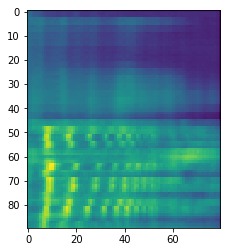

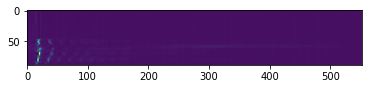

W0807 19:24:54.041167  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:24:56.591747  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:24:57.834030  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:25:38.827364  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:25:40.071647  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:25:41.881059  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:26:12.596052  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:26:14.297439  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:26:15.589733  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:26:51.898001  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:26:54.628623  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:26:56.448037  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:27:33.543483  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:27:35.958033  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:27:37.256328  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 45)
tf.Tensor(0.00040406274, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 166.9 sec
19h 27m 39s


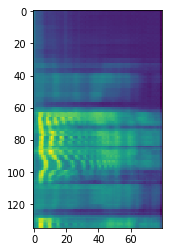

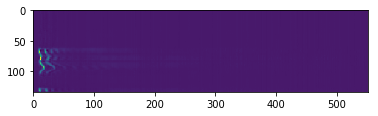

W0807 19:27:40.435052  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:27:42.145441  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:27:42.938622  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:28:18.977827  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:28:20.666213  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:28:21.997515  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:28:58.055725  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:28:59.386028  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:29:01.117422  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:29:37.269653  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:29:40.011278  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:29:41.265564  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:30:21.308681  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:30:23.062080  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:30:24.380380  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00037433827, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 167.2 sec
19h 30m 26s


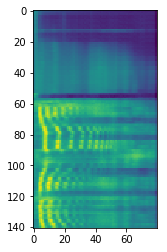

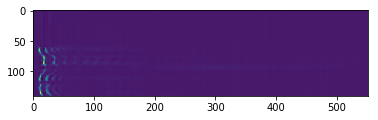

W0807 19:30:27.619117  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:30:30.808844  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:30:32.495228  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:31:11.711157  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:31:12.500337  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:31:14.234731  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:31:53.734725  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:31:54.956003  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:31:56.680395  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:32:32.394527  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:32:33.625808  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:32:35.421216  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:33:09.810046  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:33:12.500659  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:33:14.219050  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00050037197, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 169.4 sec
19h 33m 15s


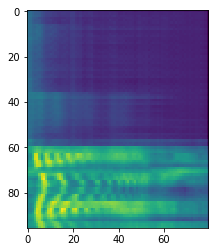

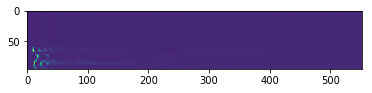

W0807 19:33:17.307754  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:33:18.546036  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:33:20.342445  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:33:57.193835  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:33:58.845211  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:34:00.675627  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:34:39.743523  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:34:41.968030  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:34:43.767440  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:35:20.564817  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:35:22.258203  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:35:23.569502  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:36:00.743965  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:36:03.411573  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:36:04.662858  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 48)
tf.Tensor(0.00035180483, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 170.9 sec
19h 36m 06s


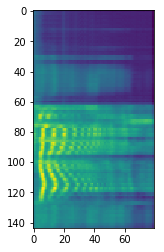

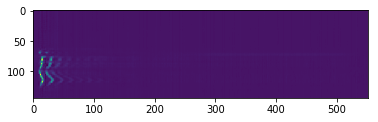

W0807 19:36:07.273452  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:36:08.521738  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:36:09.942060  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:36:15.389300  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.0005019077, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.7 sec
19h 36m 15s


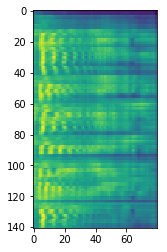

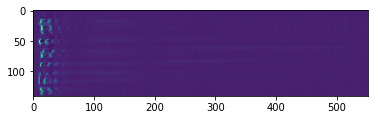

W0807 19:36:16.800621  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:36:18.509011  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:36:21.527698  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:36:59.438329  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:37:01.165723  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:37:02.523032  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:37:39.520456  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:37:41.312864  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:37:42.553146  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:38:22.595264  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:38:24.322657  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:38:26.074055  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:39:06.865344  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:39:08.637746  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:39:11.284349  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00045928775, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 177.2 sec
19h 39m 12s


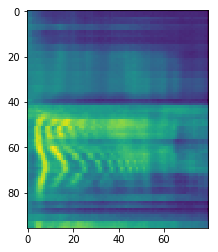

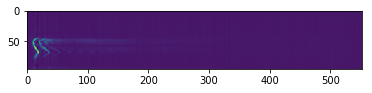

W0807 19:39:14.544092  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:39:17.343729  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:39:19.004107  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:39:57.305828  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:39:59.810398  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:40:01.540791  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:40:41.531897  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:40:43.348310  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:40:44.553586  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:41:20.234709  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:41:21.530004  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:41:24.196611  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:42:03.210494  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:42:04.981898  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:42:08.052597  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0004493148, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 176.7 sec
19h 42m 09s


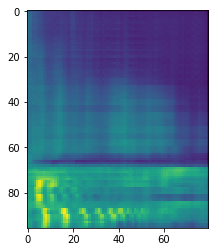

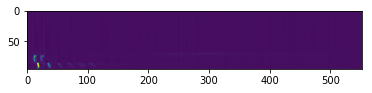

W0807 19:42:11.211316  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:42:13.813909  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:42:15.539301  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:42:55.977509  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:42:57.839933  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:43:00.386513  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:43:40.578664  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:43:43.866413  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:43:45.112696  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:44:20.541763  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:44:22.330171  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:44:25.304847  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:45:05.323959  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:45:08.561697  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:45:09.908003  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.0003497514, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.3 sec
19h 45m 11s


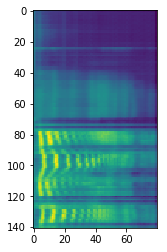

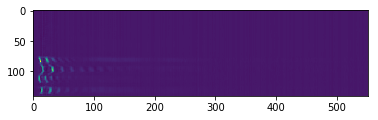

W0807 19:45:13.124736  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:45:14.776111  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:45:17.141650  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:46:00.514526  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:46:01.763810  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:46:03.356172  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:46:48.565466  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:46:51.246076  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:46:52.587382  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:47:34.359893  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:47:36.171305  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:47:37.443594  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:48:15.097168  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:48:16.337450  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:48:18.141861  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 30)
tf.Tensor(0.00053803873, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 187.8 sec
19h 48m 19s


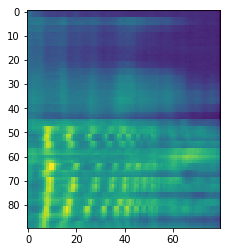

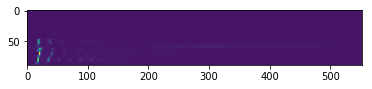

W0807 19:48:21.341590  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:48:23.800149  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:48:25.124451  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:49:06.086778  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:49:07.337063  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:49:09.152476  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:49:39.786451  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:49:41.559854  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:49:42.766129  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:50:19.226431  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:50:21.974056  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:50:23.780468  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:51:00.905920  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:51:03.394487  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:51:04.661776  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 45)
tf.Tensor(0.00039627124, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 166.9 sec
19h 51m 06s


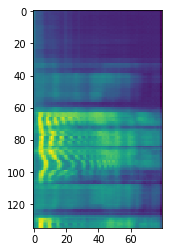

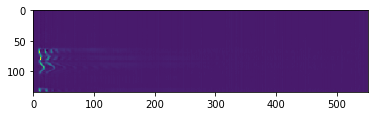

W0807 19:51:07.731475  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:51:09.535885  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:51:10.324065  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:51:46.206235  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:51:47.903621  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:51:49.246927  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:52:25.275131  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:52:26.598432  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:52:28.348830  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:53:04.511064  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:53:07.289697  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:53:08.540981  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:53:48.536087  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:53:50.275483  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:53:51.605787  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00037080515, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 167.0 sec
19h 53m 53s


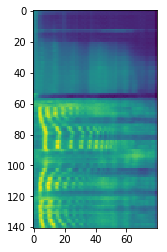

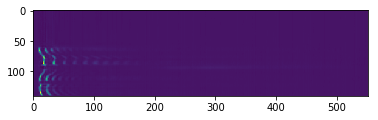

W0807 19:53:54.706493  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:53:57.941229  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:53:59.697629  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:54:38.769525  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:54:39.559705  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:54:41.284098  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:55:20.797094  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:55:22.020373  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:55:23.824784  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:55:59.549918  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:56:00.794202  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:56:02.516593  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:56:36.944432  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:56:39.659050  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:56:41.463461  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0004922663, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 169.4 sec
19h 56m 42s


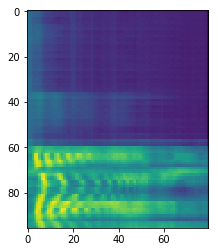

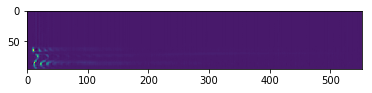

W0807 19:56:44.484148  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:56:45.773443  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:56:47.479831  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:57:24.305216  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:57:25.926585  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:57:27.712992  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:58:06.853903  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:58:09.057405  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:58:10.849813  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:58:47.551170  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:58:49.229552  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:58:50.464833  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:59:27.629295  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:59:30.192878  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:59:31.522181  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 48)
tf.Tensor(0.00034739802, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 170.5 sec
19h 59m 33s


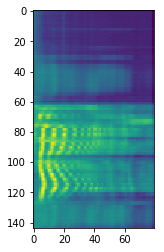

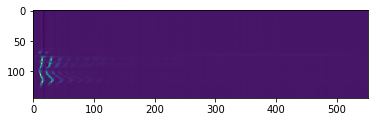

W0807 19:59:34.115772  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:59:35.357054  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:59:36.779379  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 19:59:42.261626  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.0004904817, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.8 sec
19h 59m 42s


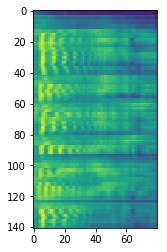

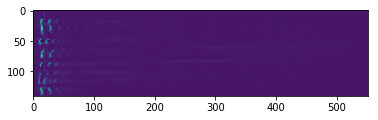

W0807 19:59:43.679949  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:59:45.409343  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 19:59:48.378019  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:00:26.451688  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:00:28.177081  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:00:29.530389  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:01:06.366776  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:01:08.148181  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:01:09.380463  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:01:49.522603  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:01:51.269000  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:01:53.031401  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:02:33.675655  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:02:35.444058  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:02:38.092661  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0004523569, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 177.2 sec
20h 02m 39s


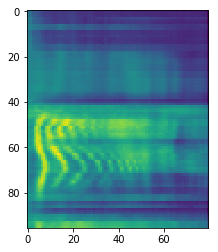

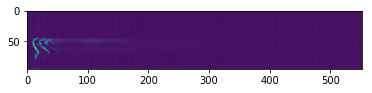

W0807 20:02:41.374408  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:02:44.155041  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:02:45.856429  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:03:24.212162  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:03:26.694726  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:03:28.427121  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:04:08.390220  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:04:10.139619  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:04:11.346894  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:04:46.951000  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:04:48.166277  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:04:50.859890  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:05:30.028809  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:05:31.813215  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:05:34.882914  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0004440867, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 176.7 sec
20h 05m 36s


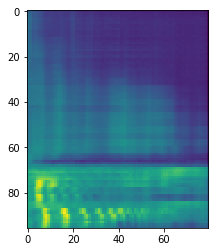

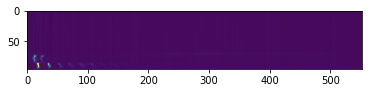

W0807 20:05:38.063638  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:05:40.655228  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:05:42.485645  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:06:22.955860  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:06:24.753268  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:06:27.309850  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:07:08.301183  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:07:11.619939  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:07:12.904232  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:07:49.231503  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:07:51.069922  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:07:54.107613  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:08:35.461029  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:08:38.892810  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:08:40.179103  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00034520225, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 185.8 sec
20h 08m 42s


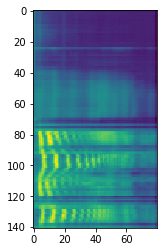

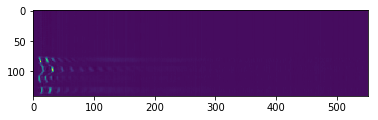

W0807 20:08:43.537868  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:08:45.229253  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:08:47.735823  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:09:33.385260  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:09:34.634544  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:09:36.252912  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:10:21.580233  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:10:24.253842  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:10:25.608150  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:11:07.340652  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:11:09.153065  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:11:10.410351  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:11:48.007911  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:11:49.338214  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:11:51.053605  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 30)
tf.Tensor(0.00052642706, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.3 sec
20h 11m 52s


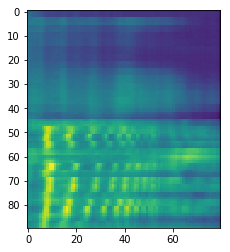

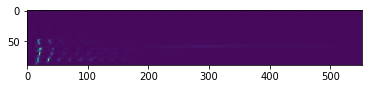

W0807 20:11:54.233329  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:11:56.757904  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:11:58.011189  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:12:38.845487  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:12:40.093771  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:12:41.905183  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:13:12.799217  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:13:14.514608  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:13:15.814904  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:13:52.283207  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:13:55.012829  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:13:56.822241  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:14:33.984703  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:14:36.411255  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:14:37.689546  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 45)
tf.Tensor(0.0003893813, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 167.1 sec
20h 14m 39s


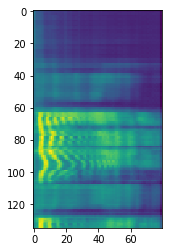

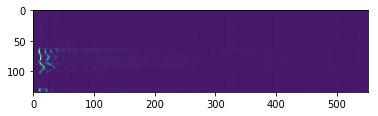

W0807 20:14:40.818258  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:14:42.603665  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:14:43.404847  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:15:19.298019  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:15:21.000407  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:15:22.261694  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:15:58.295900  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:15:59.659209  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:16:01.381601  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:16:37.886913  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:16:40.644541  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:16:41.899827  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:17:22.138988  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:17:23.954402  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:17:25.198686  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00036339564, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 167.5 sec
20h 17m 27s


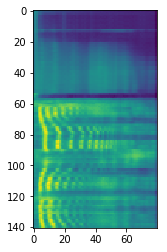

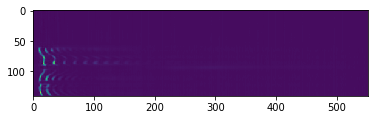

W0807 20:17:28.413418  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:17:31.599143  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:17:33.282526  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:18:12.892545  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:18:13.686726  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:18:15.477134  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:18:55.664283  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:18:56.989585  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:18:58.916024  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:19:36.485578  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:19:37.736862  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:19:39.604288  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:20:14.998347  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:20:17.730970  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:20:19.665409  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0004797189, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 174.0 sec
20h 20m 21s


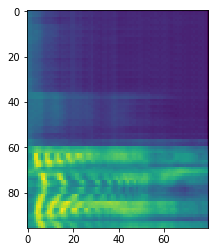

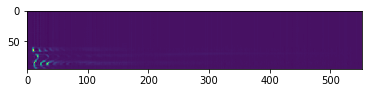

W0807 20:20:22.749111  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:20:24.059410  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:20:25.859820  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:21:03.804459  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:21:05.487843  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:21:07.388276  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:21:47.017298  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:21:49.225801  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:21:51.043215  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:22:29.553983  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:22:31.298380  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:22:32.560669  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:23:11.019424  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:23:13.672028  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:23:15.019336  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 48)
tf.Tensor(0.0003371815, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 175.8 sec
20h 23m 16s


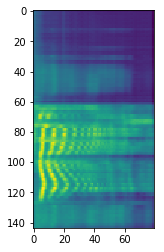

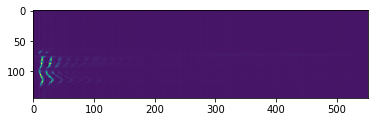

W0807 20:23:17.651936  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:23:18.904220  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:23:20.334546  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:23:25.640753  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00048729253, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.6 sec
20h 23m 25s


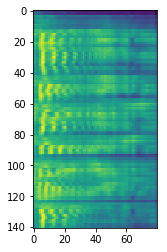

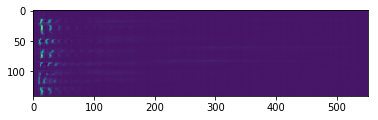

W0807 20:23:27.141095  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:23:28.919500  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:23:31.968194  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:24:10.919063  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:24:12.709470  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:24:14.058778  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:24:51.600325  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:24:53.327719  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:24:54.558999  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:25:35.994433  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:25:37.775839  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:25:39.673270  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:26:20.914662  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:26:22.748079  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:26:25.525711  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00046880267, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.2 sec
20h 26m 26s


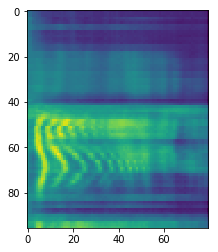

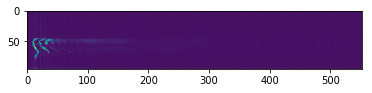

W0807 20:26:28.753446  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:26:31.586091  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:26:33.351492  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:27:12.171331  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:27:14.663899  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:27:16.391292  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:27:56.625453  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:27:58.406859  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:27:59.645140  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:28:35.246246  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:28:36.461524  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:28:39.145134  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:29:18.458085  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:29:20.219486  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:29:23.269181  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0004554166, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 177.7 sec
20h 29m 24s


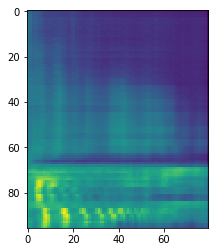

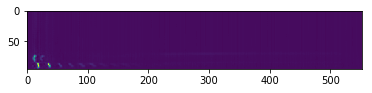

W0807 20:29:26.433901  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:29:29.047496  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:29:30.853908  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:30:11.208096  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:30:12.951493  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:30:15.519077  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:30:55.727232  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:30:59.050989  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:31:00.289271  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:31:35.710336  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:31:37.483739  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:31:40.456417  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:32:20.115446  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:32:23.383191  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:32:24.726496  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00034248602, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.9 sec
20h 32m 26s


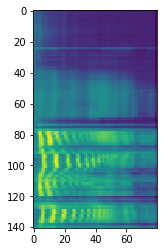

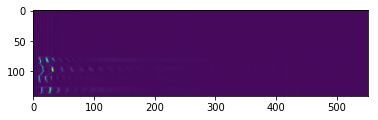

W0807 20:32:27.940227  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:32:29.573600  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:32:31.949141  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:33:15.326017  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:33:16.558297  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:33:18.155661  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:34:03.203918  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:34:05.880528  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:34:07.203829  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:34:48.827306  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:34:50.629716  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:34:51.877000  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:35:29.457557  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:35:30.781858  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:35:32.518254  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 30)
tf.Tensor(0.00051718316, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 187.3 sec
20h 35m 33s


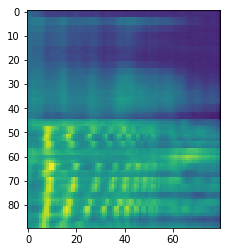

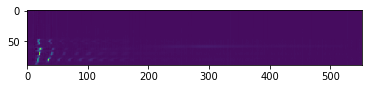

W0807 20:35:35.691977  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:35:38.251560  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:35:39.504845  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:36:20.319138  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:36:21.564421  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:36:23.358829  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:36:54.001807  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:36:55.700193  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:36:57.014493  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:37:33.124715  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:37:35.859337  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:37:37.660747  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:38:14.845214  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:38:17.243759  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:38:18.514049  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 45)
tf.Tensor(0.00038297358, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 166.4 sec
20h 38m 20s


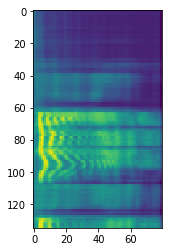

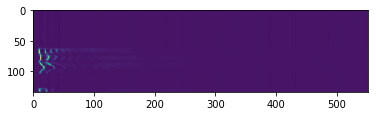

W0807 20:38:21.551741  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:38:23.330145  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:38:24.117325  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:39:00.015498  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:39:01.708884  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:39:03.032185  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:39:38.964366  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:39:40.286668  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:39:42.005059  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:40:18.039263  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:40:20.764884  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:40:21.997164  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:41:01.888247  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:41:03.632644  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:41:04.985953  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00035805453, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 166.5 sec
20h 41m 06s


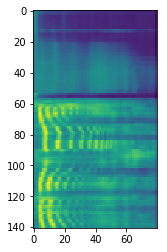

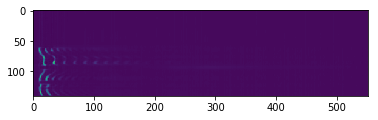

W0807 20:41:08.077656  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:41:11.302391  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:41:13.070793  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:41:52.040666  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:41:52.822845  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:41:54.622254  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:42:33.900197  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:42:35.112472  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:42:36.913883  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:43:12.519990  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:43:13.763273  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:43:15.557682  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:43:49.803479  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:43:52.456083  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:43:54.167472  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0004737597, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 168.8 sec
20h 43m 55s


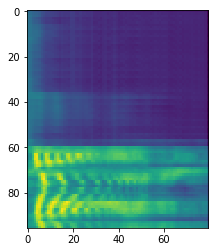

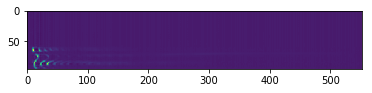

W0807 20:43:57.220167  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:43:58.523464  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:44:00.234854  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:44:36.934210  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:44:38.642599  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:44:40.355989  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:45:19.283853  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:45:21.505358  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:45:23.281763  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:45:59.767070  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:46:01.427448  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:46:02.656728  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:46:39.564131  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:46:42.130715  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:46:43.439014  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 48)
tf.Tensor(0.00033414832, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 169.7 sec
20h 46m 45s


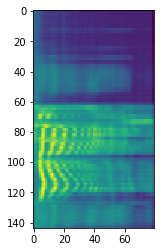

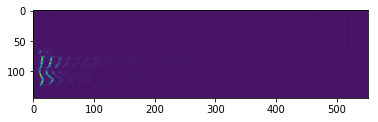

W0807 20:46:46.029603  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:46:47.273887  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:46:48.676206  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:46:54.061432  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00048625146, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.7 sec
20h 46m 54s


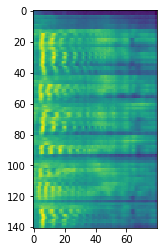

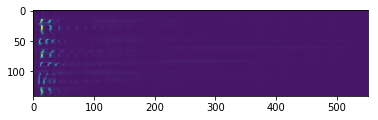

W0807 20:46:55.484756  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:46:57.201148  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:47:00.170823  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:47:37.919418  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:47:39.634809  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:47:40.957109  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:48:17.639462  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:48:19.402863  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:48:20.613139  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:49:00.350187  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:49:02.059575  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:49:03.802973  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:49:44.330200  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:49:46.095602  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:49:48.729202  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00044137263, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 176.0 sec
20h 49m 50s


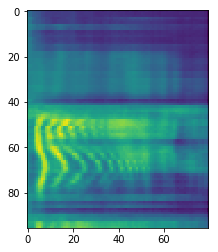

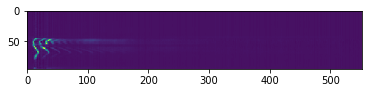

W0807 20:49:51.961938  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:49:54.727568  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:49:56.376944  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:50:34.468616  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:50:36.965184  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:50:38.682576  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:51:18.591662  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:51:20.341060  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:51:21.551336  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:51:56.879379  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:51:58.089655  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:52:00.765265  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:52:39.578102  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:52:41.340503  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:52:44.376194  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00043707425, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 175.6 sec
20h 52m 45s


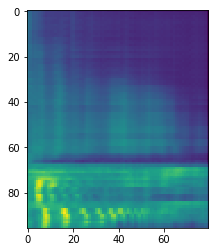

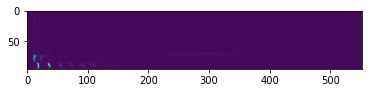

W0807 20:52:47.492904  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:52:50.091495  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:52:51.915911  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:53:32.289103  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:53:34.095515  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:53:36.629091  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:54:16.591190  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:54:19.886941  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:54:21.211242  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:54:56.628306  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:54:58.351698  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:55:01.295369  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:55:41.090430  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:55:44.377178  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:55:45.625462  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00033907258, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.8 sec
20h 55m 47s


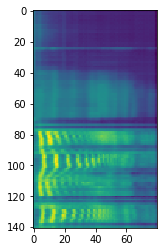

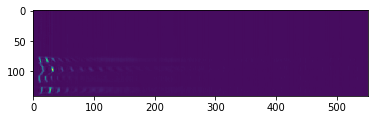

W0807 20:55:48.869201  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:55:50.515575  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:55:52.896118  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:56:36.282996  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:56:37.521278  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:56:39.139647  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:57:24.305931  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:57:27.080562  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:57:28.334848  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:58:10.508450  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:58:12.316862  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:58:13.567147  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:58:51.465776  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:58:52.719061  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:58:54.565481  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 30)
tf.Tensor(0.0005105319, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 188.4 sec
20h 58m 55s


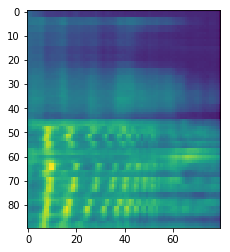

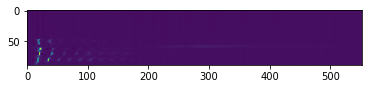

W0807 20:58:57.815222  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:59:00.261778  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:59:01.635091  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 20:59:42.764456  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:59:44.012740  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 20:59:45.740133  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:00:16.916232  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:00:18.659628  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:00:19.881907  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:00:56.458235  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:00:59.227865  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:01:01.033277  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:01:38.089713  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:01:40.580281  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:01:41.857572  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 45)
tf.Tensor(0.00037901182, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 167.7 sec
21h 01m 43s


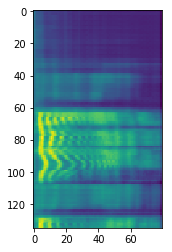

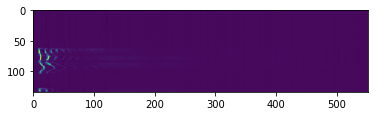

W0807 21:01:44.946275  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:01:46.767690  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:01:47.588877  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:02:24.237221  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:02:25.978617  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:02:27.331926  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:03:05.606641  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:03:07.018962  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:03:08.867383  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:03:46.908045  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:03:49.854715  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:03:51.151010  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:04:34.672919  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:04:36.719385  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:04:38.314749  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00035450637, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 176.8 sec
21h 04m 40s


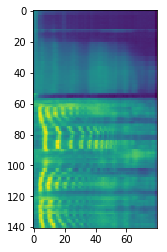

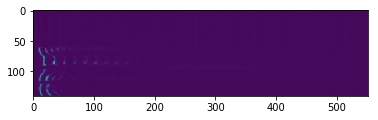

W0807 21:04:41.994586  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:04:45.309341  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:04:47.168764  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:05:28.435160  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:05:29.255347  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:05:31.166783  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:06:11.738020  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:06:12.990305  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:06:14.890738  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:06:52.138218  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:06:53.518533  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:06:55.341948  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:07:30.476947  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:07:33.288588  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:07:35.132008  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00046999755, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 176.1 sec
21h 07m 36s


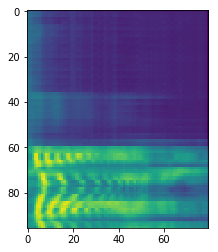

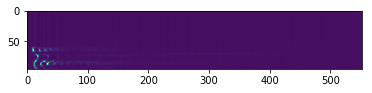

W0807 21:07:38.179702  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:07:39.536010  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:07:41.311415  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:08:19.535117  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:08:21.301519  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:08:23.122934  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:09:03.688171  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:09:06.038706  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:09:07.879125  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:09:46.271866  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:09:48.108285  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:09:49.643635  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:10:31.847244  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:10:34.862930  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:10:36.314260  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 48)
tf.Tensor(0.00033014984, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.7 sec
21h 10m 38s


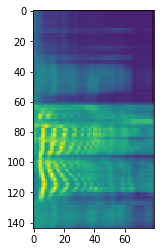

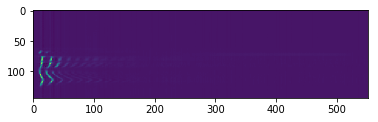

W0807 21:10:39.174914  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:10:40.644248  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:10:42.234608  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:10:48.386008  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00048162264, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 3.1 sec
21h 10m 48s


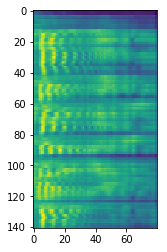

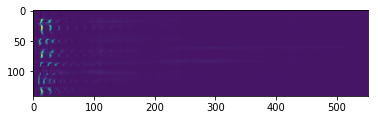

W0807 21:10:49.832339  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:10:51.586738  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:10:54.695446  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:11:34.981620  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:11:37.023084  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:11:38.456409  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:12:18.078430  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:12:19.906847  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:12:21.165134  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:13:02.682586  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:13:04.510003  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:13:06.325416  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:13:48.072922  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:13:49.888334  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:13:52.579948  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.0004387427, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 185.6 sec
21h 13m 54s


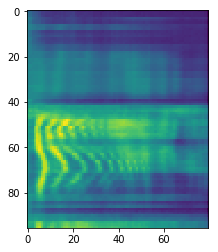

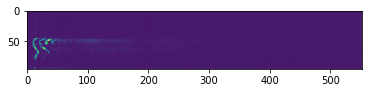

W0807 21:13:55.970719  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:13:58.825369  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:14:00.515754  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:14:40.067760  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:14:42.627343  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:14:44.426752  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:15:26.114244  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:15:27.859641  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:15:29.087921  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:16:06.077343  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:16:07.360635  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:16:10.151271  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:16:50.076361  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:16:51.866768  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:16:55.092504  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00043297117, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.5 sec
21h 16m 56s


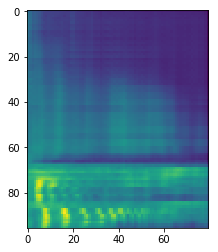

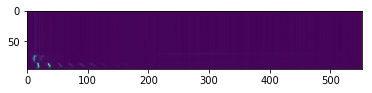

W0807 21:16:58.617306  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:17:01.371933  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:17:03.146337  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:17:45.670019  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:17:47.583455  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:17:50.129034  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:18:32.774744  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:18:36.246534  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:18:37.583840  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:19:14.476239  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:19:16.295653  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:19:19.348348  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:20:00.884806  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:20:04.250572  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:20:05.608881  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00033678982, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.9 sec
21h 20m 07s


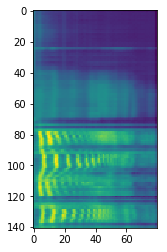

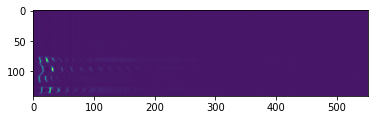

W0807 21:20:08.894629  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:20:10.596017  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:20:13.022569  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:20:58.243866  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:20:59.592173  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:21:01.334569  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:21:48.387284  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:21:51.136909  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:21:52.485215  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:22:35.933881  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:22:37.854318  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:22:39.202625  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:23:18.660609  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:23:19.955904  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:23:21.849335  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 30)
tf.Tensor(0.00050319935, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 195.8 sec
21h 23m 23s


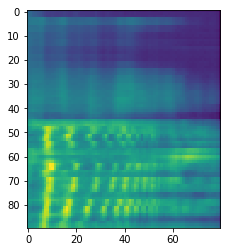

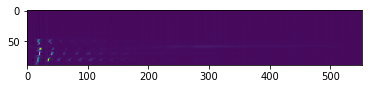

W0807 21:23:25.266113  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:23:27.895712  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:23:29.301032  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:24:12.901959  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:24:14.207256  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:24:16.085684  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:24:49.520297  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:24:51.383721  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:24:52.657012  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:25:31.575873  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:25:34.429522  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:25:36.265940  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:26:14.757704  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:26:17.363297  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:26:18.717606  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 45)
tf.Tensor(0.00037284783, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 177.3 sec
21h 26m 20s


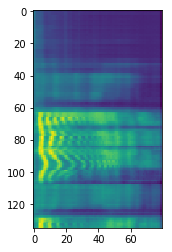

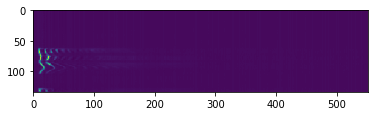

W0807 21:26:21.891328  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:26:23.708742  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:26:24.507924  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:27:02.027467  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:27:03.748859  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:27:05.110169  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:27:41.808524  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:27:43.129826  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:27:44.894227  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:28:21.698608  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:28:24.484241  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:28:25.759531  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:29:06.548818  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:29:08.307219  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:29:09.705537  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 47)
tf.Tensor(0.00035190687, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 171.0 sec
21h 29m 11s


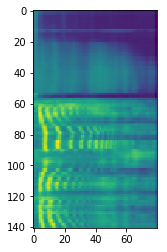

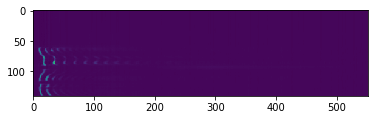

W0807 21:29:12.870258  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:29:16.087990  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:29:17.896402  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:29:57.561435  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:29:58.351614  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:30:00.175029  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:30:41.499438  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:30:42.822739  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:30:44.917216  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:31:23.983111  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:31:25.363425  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:31:27.344876  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:32:04.758395  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:32:07.707066  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:32:09.580492  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00046613056, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 179.6 sec
21h 32m 11s


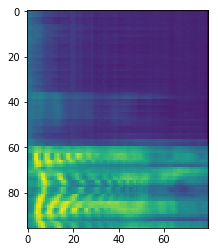

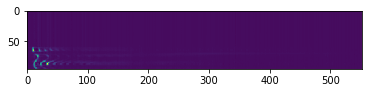

W0807 21:32:12.780221  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:32:14.127527  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:32:15.945942  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:32:55.598973  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:32:57.431387  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:32:59.520864  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:33:41.514425  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:33:44.005992  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:33:46.057459  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:34:24.693256  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:34:26.551680  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:34:27.994007  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:35:07.224940  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:35:09.879544  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:35:11.227851  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 48)
tf.Tensor(0.00032827904, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.0 sec
21h 35m 13s


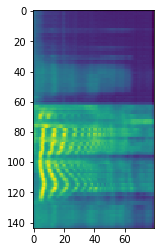

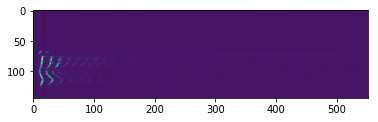

W0807 21:35:13.922465  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:35:15.084730  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:35:16.536060  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:35:22.125333  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00047808225, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.9 sec
21h 35m 22s


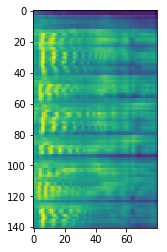

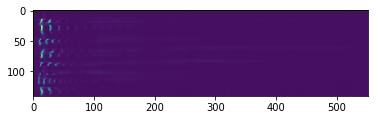

W0807 21:35:23.550657  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:35:25.277050  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:35:28.286735  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:36:06.860518  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:36:08.622920  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:36:09.909213  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:36:47.621798  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:36:49.348193  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:36:50.581473  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:37:31.310747  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:37:33.062145  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:37:34.834548  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:38:16.993148  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:38:18.834567  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:38:21.838251  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00043350508, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.1 sec
21h 38m 23s


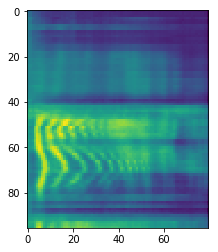

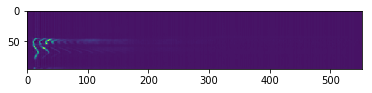

W0807 21:38:25.330046  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:38:28.320727  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:38:30.225162  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:39:10.331292  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:39:12.803855  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:39:14.524246  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:39:55.071478  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:39:56.922900  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:39:58.202192  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:40:34.777519  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:40:36.069813  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:40:38.730419  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:41:18.068376  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:41:19.865785  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:41:22.862467  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

(16, 32)
tf.Tensor(0.00043087706, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.0 sec
21h 41m 24s


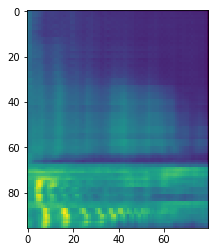

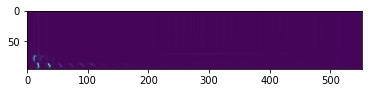

W0807 21:41:26.115208  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:41:28.737805  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:41:30.562220  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

W0807 21:42:12.707816  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:42:14.522047  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing the loss.
W0807 21:42:17.179417  1724 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/recurrent_kernel:0', 'decoder_rnn_3/stacked_residual_rnn_3/residual_gru_6/gru_17/bias:0'] when minimizing th

KeyboardInterrupt: 

In [26]:
# Started hour
print(time.strftime("%Hh %Mm %Ss"))


for epoch in range(10):

    start = time.time()

    for i, (mel, linear, texts) in enumerate(tqdm((dataset))):

        loss, spec, mel = tacotron.train(mel, linear, texts)

        if i % 100 == 0:
            print(texts.shape)    
            print(loss)
            print('Time taken for 100 * 16 samples: {:.1f} sec'.format(time.time() - start))
            print(time.strftime("%Hh %Mm %Ss"))
            start = time.time()

            plt.figure()
            plt.imshow(spec[0])
            plt.show()

            plt.figure()
            plt.imshow(mel[0])
            plt.show()

            print('')